<a href="https://colab.research.google.com/github/eunzzae/FC_Project_essay/blob/main/ML%EC%BA%90%EA%B8%80%ED%94%8C%EC%A0%9D_%EC%97%90%EC%84%B8%EC%9D%B4%ED%92%88%EC%A7%88%EC%98%88%EC%B8%A1_EDA_%EC%BB%AC%EB%9F%BC%EB%B3%84_%ED%8A%B9%EC%A7%95_231013.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib as mpl
import math
import gc
import pprint

%matplotlib inline


In [3]:
data_path = '/content/drive/MyDrive/Colab Notebooks/data/essay_quality/'

train_logs = pd.read_csv(data_path+'train_logs.csv')
train_scores = pd.read_csv(data_path+'train_scores.csv')
test_logs = pd.read_csv(data_path+'test_logs.csv')
submission = pd.read_csv(data_path+'sample_submission.csv')

In [4]:
train_logs.head()

,id,event_id,down_time,up_time,action_time,activity,down_event,up_event,text_change,cursor_position,word_count
0,001519c8,1,4526,4557,31,Nonproduction,Leftclick,Leftclick,NoChange,0,0
1,001519c8,2,4558,4962,404,Nonproduction,Leftclick,Leftclick,NoChange,0,0
2,001519c8,3,106571,106571,0,Nonproduction,Shift,Shift,NoChange,0,0
3,001519c8,4,106686,106777,91,Input,q,q,q,1,1
4,001519c8,5,107196,107323,127,Input,q,q,q,2,1


In [5]:
train_scores.head()

,id,score
0,001519c8,3.5
1,0022f953,3.5
2,0042269b,6.0
3,0059420b,2.0
4,0075873a,4.0


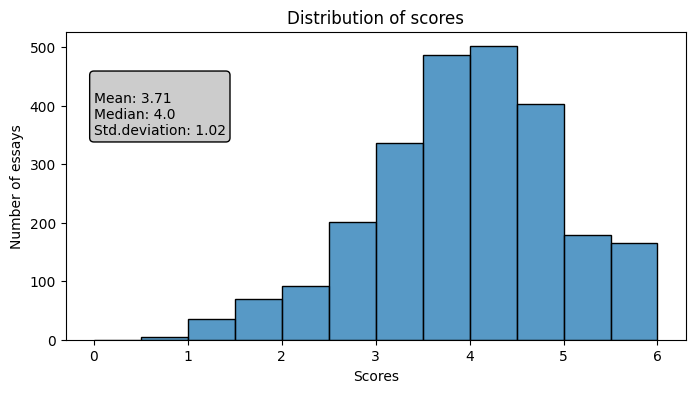

In [6]:
event_stats = train_scores['score']
text = f"""
Mean: {event_stats.mean().round(2)}
Median: {event_stats.median().round(2)}
Std.deviation: {event_stats.std().round(2)}"""

box_plot = dict(boxstyle = 'round', fc='0.8')

fig, ax = plt.subplots(1, 1, figsize=(8,4))
ax.set_title('Distribution of scores')
ax.set_xlabel('Scores')
ax.set_ylabel('Number of essays')
sns.histplot(event_stats, bins=np.arange(0, 6.5, 0.5))
ax.annotate(text, (0,350), bbox=box_plot)
plt.show()

### event

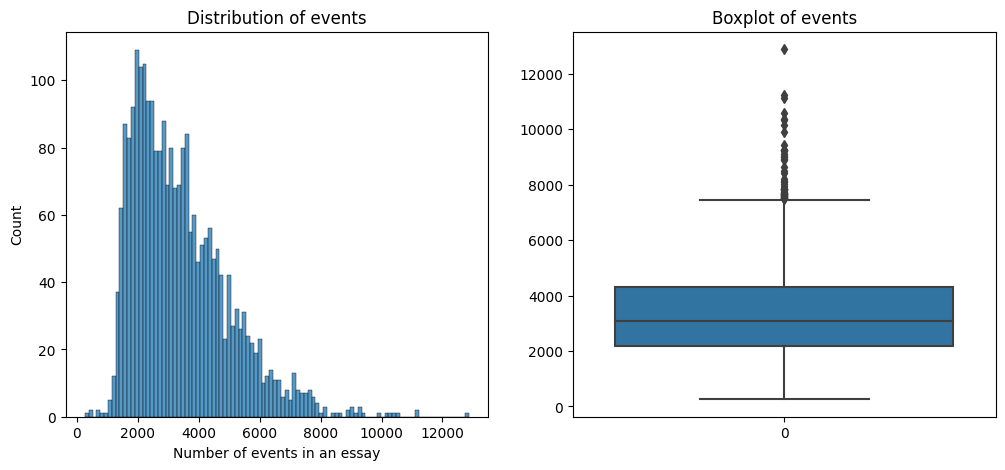

In [7]:
event_stats = train_logs.groupby('id')['event_id'].max()

fig, ax = plt.subplots(1, 2, figsize=(12,5))
ax[0].set_title('Distribution of events')
ax[0].set_xlabel('Number of events in an essay')
sns.histplot(event_stats, bins=100, ax=ax[0])
ax[1].set_title('Boxplot of events')
sns.boxplot(event_stats, ax=ax[1])
plt.show()

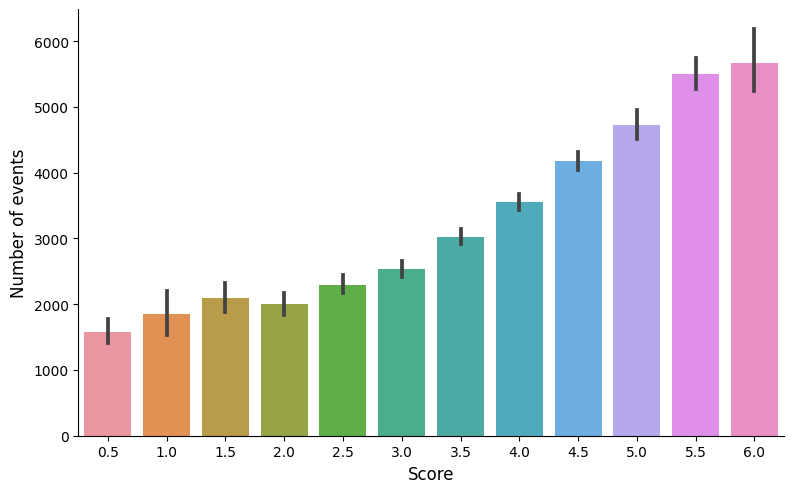

In [8]:
# event 수에 따른 score 분포
stats = train_logs.groupby('id')['event_id'].max().reset_index()
stats_score = stats.merge(train_scores, on='id')

catplot = sns.catplot(data=stats_score, x='score', y='event_id', kind='bar', height=5, aspect=8/5)
plt.xlabel('Score', fontsize=12)
plt.ylabel('Number of events', fontsize=12)
plt.show()

### time

In [9]:
tmp = train_logs['up_time'] -train_logs['down_time']
results = (tmp == train_logs['action_time'])
results.value_counts()

True    8405898
dtype: int64

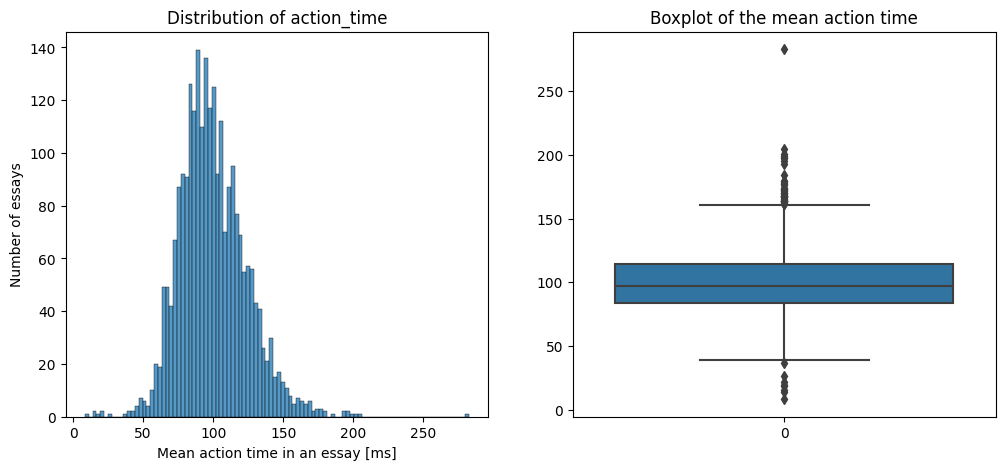

In [10]:
stats = train_logs.groupby('id')['action_time'].mean()

fig, ax = plt.subplots(1, 2, figsize=(12, 5))
ax[0].set_title('Distribution of action_time')
ax[0].set_xlabel('Mean action time in an essay [ms]')
ax[0].set_ylabel('Number of essays')
sns.histplot(stats, bins=100, ax=ax[0])
ax[1].set_title('Boxplot of the mean action time')
sns.boxplot(stats, ax=ax[1])
plt.show()

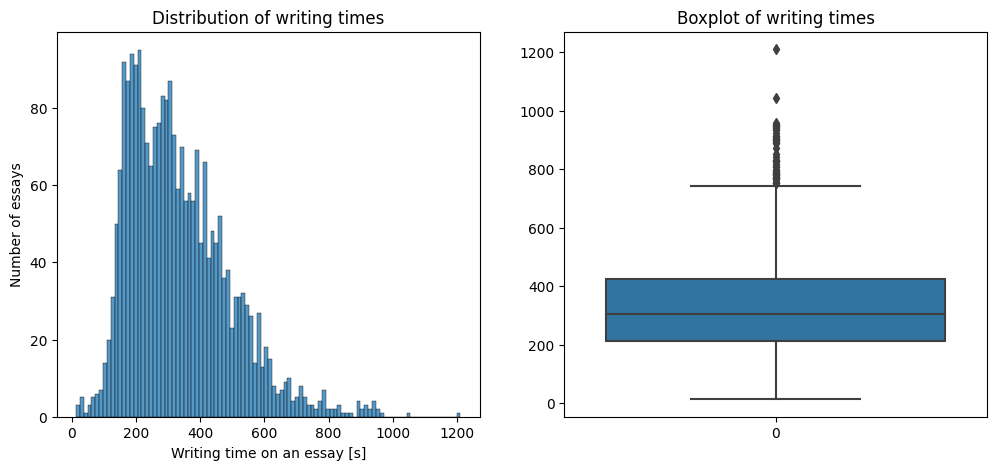

In [11]:
stats = train_logs.groupby("id")["action_time"].sum().div(1000)

fig, ax = plt.subplots(1,2, figsize=(12,5))
ax[0].set_title('Distribution of writing times')
ax[0].set_xlabel('Writing time on an essay [s]')
ax[0].set_ylabel('Number of essays')
sns.histplot(stats, bins=100, ax=ax[0])
ax[1].set_title('Boxplot of writing times')
sns.boxplot(stats, ax=ax[1])
plt.show()

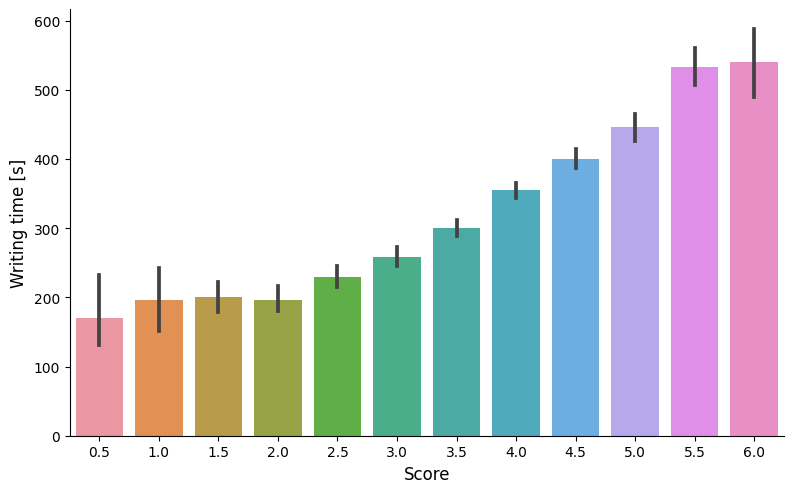

In [12]:
stats = train_logs.groupby("id")["action_time"].sum().div(1000).reset_index()
stats_score = stats.merge(train_scores, on='id')

catplot = sns.catplot(data=stats_score, x="score", y="action_time", kind="bar", height=5, aspect=8/5)
plt.xlabel('Score', fontsize=12)
plt.ylabel('Writing time [s]', fontsize=12)
plt.show()

### activity

### down_event, up_event

In [13]:
train_logs['down_event'].value_counts()[:20]

q               5365319
Space           1207128
Backspace        964089
Shift            334227
ArrowRight       121338
Leftclick         91126
ArrowLeft         63217
.                 59586
,                 46806
ArrowDown         30874
ArrowUp           28189
Enter             22689
CapsLock          12568
'                 11170
Delete            10965
Unidentified       6151
Control            4885
"                  4102
-                  3843
?                  3155
Name: down_event, dtype: int64

In [14]:
print(f'Number of unique down events: {train_logs["down_event"].nunique()}')
print(f'Number of unique up events: {train_logs["up_event"].nunique()}')

Number of unique down events: 131
Number of unique up events: 130


In [15]:
set(train_logs['up_event'].unique()).difference(set(train_logs['down_event'].unique()))

{'k'}

In [16]:
set(train_logs['down_event'].unique()).difference(set(train_logs['up_event'].unique()))

{'F', 'I'}

In [17]:
event_stats = train_logs[['down_event', 'up_event', 'action_time']]
event_stats = event_stats.groupby('down_event')['action_time'].mean().sort_values()
event_stats[:20]

down_event
j                      0.000000
l                      0.000000
F1                     0.000000
Pause                  0.000000
Control                0.000000
Shift                  0.000000
T                      0.000000
Alt                    0.000000
F6                     0.000000
f                      0.200000
F15                    0.333333
2                      2.333333
ScrollLock             3.259259
Â´                     7.000000
                      7.000000
Cancel                11.000000
¿                     30.500000
u                     30.666667
Unknownclick          32.333333
MediaTrackPrevious    33.500000
Name: action_time, dtype: float64

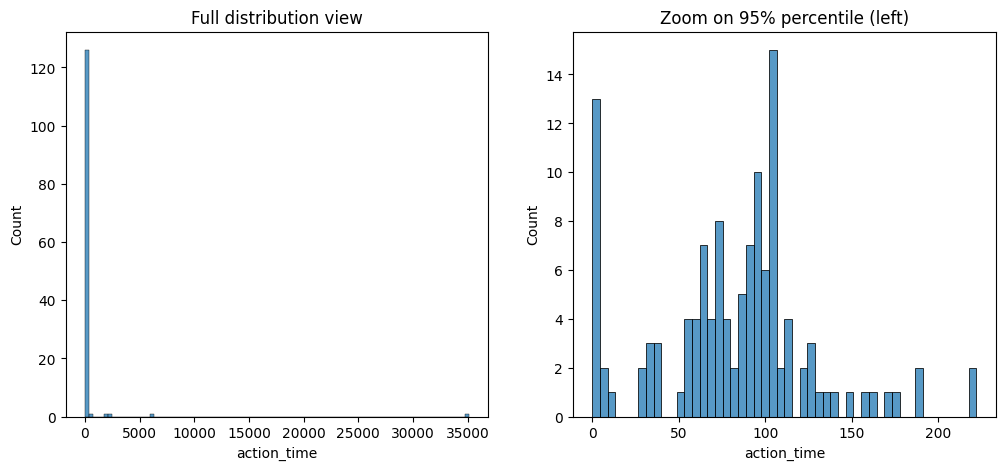

In [18]:
fig, ax = plt.subplots(1,2, figsize=(12,5))
ax[0].set_title('Full distribution view')
sns.histplot(event_stats, bins=100, ax=ax[0])
ax[1].set_title('Zoom on 95% percentile (left)')
event_stats_95 = event_stats[event_stats<event_stats.quantile(0.95)]
sns.histplot(event_stats_95, bins=50, ax=ax[1])
plt.show()

### cursor_position

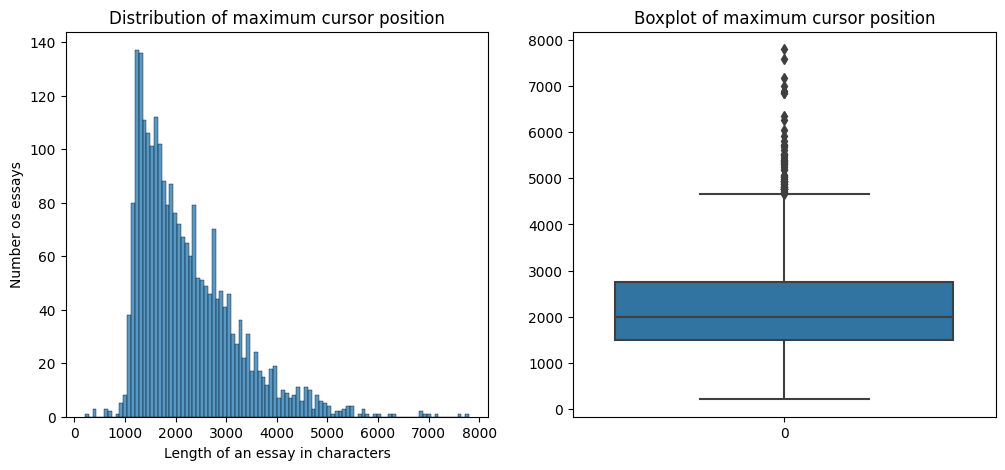

In [19]:
event_stats = train_logs.groupby("id")['cursor_position'].max()

fig, ax = plt.subplots(1,2, figsize=(12,5))
ax[0].set_title('Distribution of maximum cursor position')
ax[0].set_xlabel('Length of an essay in characters')
ax[0].set_ylabel('Number os essays')
sns.histplot(event_stats, bins=100, ax=ax[0])
ax[1].set_title('Boxplot of maximum cursor position')
sns.boxplot(event_stats, ax=ax[1])
plt.show()

### word count

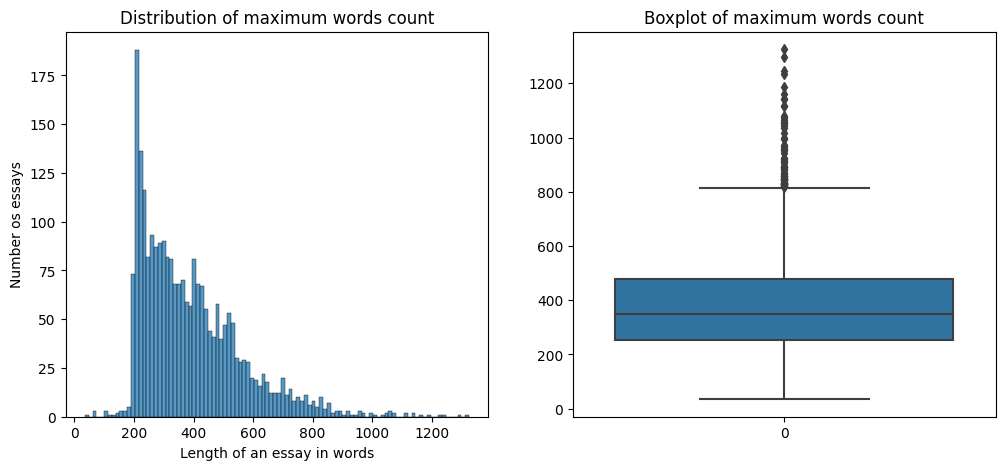

In [20]:
event_stats = train_logs.groupby("id")['word_count'].max()

fig, ax = plt.subplots(1,2, figsize=(12,5))
ax[0].set_title('Distribution of maximum words count')
ax[0].set_xlabel('Length of an essay in words')
ax[0].set_ylabel('Number os essays')
sns.histplot(event_stats, bins=100, ax=ax[0])
ax[1].set_title('Boxplot of maximum words count')
sns.boxplot(event_stats, ax=ax[1])
plt.show()

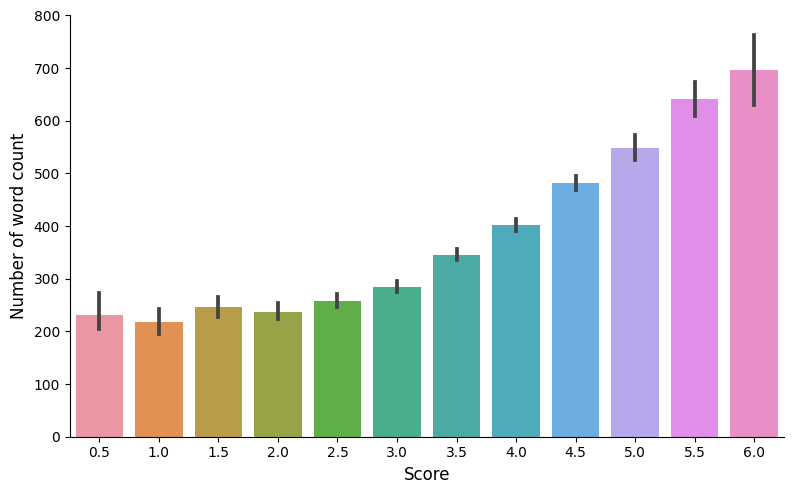

In [21]:
# word count 수에 따른 score 분포
stats = train_logs.groupby('id')['word_count'].max().reset_index()
stats_score = stats.merge(train_scores, on='id')

catplot = sns.catplot(data=stats_score, x='score', y='word_count', kind='bar', height=5, aspect=8/5)
plt.xlabel('Score', fontsize=12)
plt.ylabel('Number of word count', fontsize=12)
plt.show()

In [22]:
train_logs['action'] = np.where(train_logs['activity'].str.contains("Move"),  'Move', train_logs['activity'])

activity_avg_num = train_logs.groupby(['action']).count().reset_index()[['action','event_id']].sort_values(by = 'event_id', ascending = False)
activity_avg_num['avg_activity_num'] = round(activity_avg_num['event_id'] / train_logs['id'].nunique(),2)

AttributeError: ignored

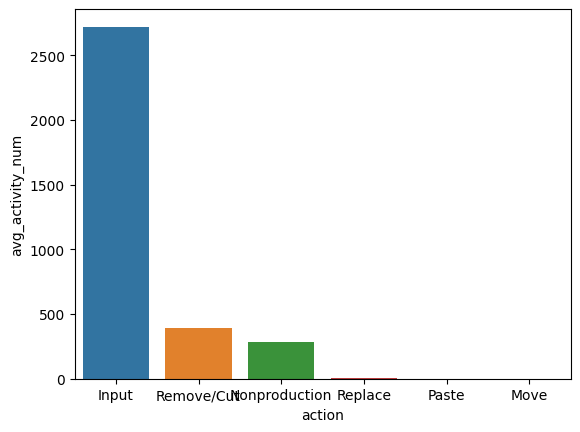

In [23]:
fig = sns.barplot(activity_avg_num, x='action', y='avg_activity_num')

fig.update_layout(
    title="Avg. occurrences of each activity type by essay",
    x_label="Activity type",
    y_label="Avg. number of occurrence",
    font=dict(
        size=15
    )
)

In [ ]:
median_action_time = train_logs[['action','action_time']].groupby(['action']).median().reset_index().sort_values(by = 'action_time', ascending = False)

fig = sns.barplot(median_action_time, x='action', y='action_time')

fig.update_layout(
    title="Median action time by activity type",
    x_label="Activity type",
    y_label="Action time (ms)",
    font=dict(
        size=15
    )
)
fig.show()